In [1]:
import findspark #look up my local spark
findspark.init()


In [2]:
from pyspark.sql import SparkSession #start spark session
#PySpark:is a library for Apache Spark, which is a distributed computing framework
#.sql:perform SQL-like operations on DataFrames, making it easier to manipulate and analyze large dataset

# Create a Spark session
spark = SparkSession.builder.master("local[*]").appName("MyApp").getOrCreate() #on my local

# Check if the Spark session is active
spark


In [3]:
# Load my data 
df = spark.read.csv("C:\\Users\\renad\\OneDrive\\Desktop\\cloud and big data project\\data\\movies_metadata.csv", header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show()


+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------+--------------------+-----------------+
|adult|belongs_to_collection|  budget|              genres|            homepage|   id|  imdb_id|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|        release_date|             revenue|             runtime|    spoken_languages|  status|             tagline|               title|   video|        vote_average|       vote_count|
+-----+---------------------+--------+--------------------+--------------------+-----+---------+-----------------+--------------------+--------------------+----------+-----

In [4]:
#the columns im intrested in ,my current data frame
selected_columns=df.select("id","budget","vote_average")
print(selected_columns)
#by default, Spark treats the JSON data in the column as a string,so ww will have to deal with that

DataFrame[id: string, budget: string, vote_average: string]


In [5]:
from pyspark.sql.functions import trim,col
#handleing casting with white space since its a string so it wont be null after casting

selected_columns = selected_columns.withColumn("budget", trim(col("budget")))
selected_columns = selected_columns.withColumn("vote_average", trim(col("vote_average")))


In [6]:
#for this section ill clean all columns but the json for later

##col:function is used to refer to a DataFrame column by name. It allows you to perform various operation,like casting a col
selected_columns = selected_columns.withColumn("budget", col("budget").cast("float"))
selected_columns = selected_columns.withColumn("vote_average", col("vote_average").cast("float"))
selected_columns.printSchema()




root
 |-- id: string (nullable = true)
 |-- budget: float (nullable = true)
 |-- vote_average: float (nullable = true)



In [7]:
#Check for Missing Values [null]

print("Before fixing null values:")
selected_columns.filter(
    selected_columns.id.isNull() | 
    selected_columns.budget.isNull() | 
    selected_columns.vote_average.isNull()
).show()

# Drop rows where either 'budget' or 'vote_average' is null
# Since both are critical to my analysis
selected_columns = selected_columns.dropna(subset=["budget", "vote_average"])

# Check for Missing Values [null] after fixing
print("After fixing null values:")
selected_columns.filter(
    selected_columns.id.isNull() | 
    selected_columns.budget.isNull() | 
    selected_columns.vote_average.isNull() 
).show()



Before fixing null values:
+----------+---------+------------+
|        id|   budget|vote_average|
+----------+---------+------------+
|     31357|    1.6E7|        NULL|
|      8012|  3.025E7|        NULL|
|       902|    1.8E7|        NULL|
|     11443|    1.0E7|        NULL|
|       807|    3.3E7|        NULL|
|      9536|    1.5E7|        NULL|
|      9623|    4.4E7|        NULL|
|    188588|      0.0|        NULL|
|      9283|      0.0|        NULL|
|     63076|      0.0|        NULL|
|    290157|      0.0|        NULL|
|1995-01-01|     NULL|        NULL|
|     55475|      0.0|        NULL|
|    124636|      0.0|        NULL|
|      5757|      0.0|        NULL|
|      8839|    5.0E7|        NULL|
|     17447|      0.0|        NULL|
|      9344|1500000.0|        NULL|
|     47608|      0.0|        NULL|
|     18402|      0.0|        NULL|
+----------+---------+------------+
only showing top 20 rows

After fixing null values:
+---+------+------------+
| id|budget|vote_average|
+---+

In [8]:
#drop duplicates rows ill measure by id, method of pyspark takes a sub set[] inside the col name 
selected_columns = selected_columns.dropDuplicates(["id"])

In [9]:
#trim whitespace 
selected_columns = selected_columns.withColumn("id", trim(col("id")))




In [10]:
# Print the column names to check the schema
column_names = selected_columns.columns
print(column_names)




['id', 'budget', 'vote_average']


In [11]:
selected_columns.printSchema()





root
 |-- id: string (nullable = true)
 |-- budget: float (nullable = true)
 |-- vote_average: float (nullable = true)



In [12]:
#why are all budget showing 0?
# Remove rows with a budget of 0
selected_columns = selected_columns.filter(selected_columns.budget > 0)#are we removing them
# Check remaining rows after filtering
print("Remaining rows after removing zero budget:")
selected_columns.show()



Remaining rows after removing zero budget:
+-----+---------+------------+
|   id|   budget|vote_average|
+-----+---------+------------+
| 1572|    9.0E7|         6.9|
|10436|    3.4E7|         7.0|
| 2088|   1.15E7|         5.7|
|38223|    1.2E7|         5.7|
|  829|6000000.0|         7.9|
| 5925|4000000.0|         7.8|
|10351|5000000.0|         5.6|
| 1090|    1.6E7|         6.8|
| 2162|    7.0E7|         5.3|
| 9586|    4.7E7|         5.3|
| 2069|   4.13E7|         6.3|
|  691|    1.4E7|         6.6|
|32275|6000000.0|         6.2|
| 2294|    2.2E7|         6.4|
|11888|    3.3E7|         5.3|
|  451|3600000.0|         7.1|
|28288| 520000.0|         7.2|
| 2756|    7.0E7|         7.1|
|10603|    5.5E7|         5.4|
| 9407|    4.8E7|         5.9|
+-----+---------+------------+
only showing top 20 rows



In [13]:
from pyspark.ml.feature import VectorAssembler # ml only can take vector so 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator #evalute ur modle
#ml configration i wanna implment linear reggersion,no need for id
selected_columns = selected_columns.drop("id")
selected_columns.show()
#budget is my feature[input] my label is vote[the dependent variable]

#ml expect input as a form of vector

# Step 1: Create a feature vector for budget ,creating a new column called features
assembler = VectorAssembler(inputCols=["budget"], outputCol="features")
assembled_data = assembler.transform(selected_columns)

# Step 2: Split the data into training 80% and test 20% 
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=123)

# Step 3: Set up the linear regression model get my selected columns for predictions
lr = LinearRegression(featuresCol="features", labelCol="vote_average")

# Step 4: Train the model on the training data
lr_model = lr.fit(train_data)

# Step 5: Output the model's coefficients and intercept
#coefficients and intercept is a crucial part of understanding how the linear regression model predicts outcomes y=mx+b
# generalization based on the relationships identified across all of your training data
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

# Step 6: Make predictions on the test data the 20%
predictions = lr_model.transform(test_data)
predictions.select("budget", "vote_average", "prediction").show()

# Step 7: Evaluate the model using RMSE (Root Mean Squared Error) this is the standard for linear reggrssion
evaluator = RegressionEvaluator(labelCol="vote_average", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")





+---------+------------+
|   budget|vote_average|
+---------+------------+
|    9.0E7|         6.9|
|    3.4E7|         7.0|
|   1.15E7|         5.7|
|    1.2E7|         5.7|
|6000000.0|         7.9|
|4000000.0|         7.8|
|5000000.0|         5.6|
|    1.6E7|         6.8|
|    7.0E7|         5.3|
|    4.7E7|         5.3|
|   4.13E7|         6.3|
|    1.4E7|         6.6|
|6000000.0|         6.2|
|    2.2E7|         6.4|
|    3.3E7|         5.3|
|3600000.0|         7.1|
| 520000.0|         7.2|
|    7.0E7|         7.1|
|    5.5E7|         5.4|
|    4.8E7|         5.9|
+---------+------------+
only showing top 20 rows

Coefficients: [0.005266067916217216]
Intercept: 13266.065449689728
+------+------------+------------------+
|budget|vote_average|        prediction|
+------+------------+------------------+
|   1.0|         4.0|13266.070715757643|
|   1.0|         5.1|13266.070715757643|
|   1.0|         6.4|13266.070715757643|
|   1.0|         6.4|13266.070715757643|
|   1.0|         7.5

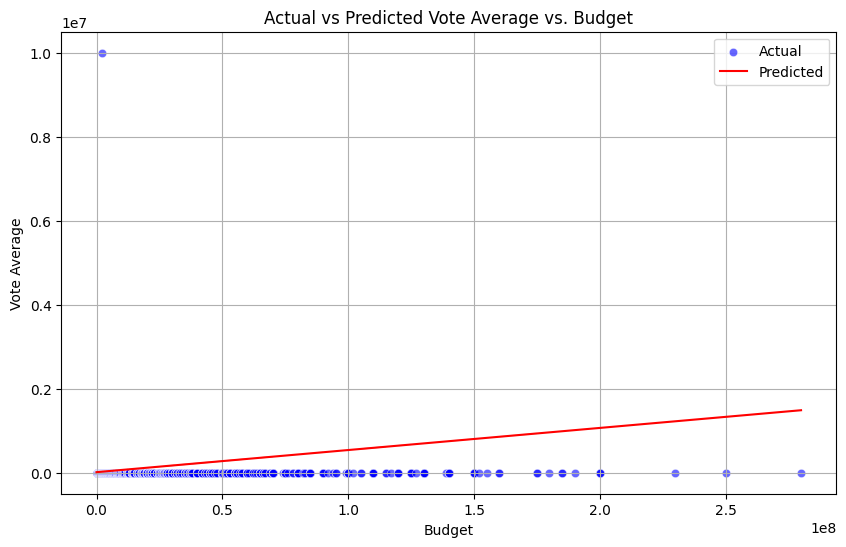

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the columns for budget, actual vote_average, and predicted vote_average and turn them to pandas data frame
x = predictions.select("budget").toPandas()
y_actual = predictions.select("vote_average").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Create a scatter plot of actual vote_average vs budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x['budget'], y=y_actual['vote_average'], label="Actual", alpha=0.6, color='blue')


sns.lineplot(x=x['budget'], y=y_pred['prediction'], label="Predicted", color='red')

# Adding labels and title
plt.title("Actual vs Predicted Vote Average vs. Budget")
plt.xlabel("Budget")
plt.ylabel("Vote Average")

# Show the plot
plt.grid()
plt.legend()
plt.show()
